In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func
from config import *

In [2]:
# create an engine to postgresql db
user = config['psql_user']
password = config['psql_pwd']
host = 'localhost'
port = '5432'
db = config['psql_db']
url = 'postgresql://{}:{}@{}:{}/{}'
url = url.format(user, password, host, port, db)

# The return value of create_engine() is our connection object
engine = sqlalchemy.create_engine(url, client_encoding='utf8')

In [3]:
query = 'SELECT * FROM positions'
df_pos = pd.read_sql_query(query, engine)
df_pos["mval"] = df_pos["mval"] * 1000
df_pos.head()

,id,file_date,name,cusip,mval,shares
0,1,2013-06-30,AMERICAN EXPRESS CO,025816109,145942000,1952142
1,2,2013-06-30,AMERICAN EXPRESS CO,025816109,1287771000,17225400
2,3,2013-06-30,AMERICAN EXPRESS CO,025816109,62786000,839832
3,4,2013-06-30,AMERICAN EXPRESS CO,025816109,145266000,1943100
4,5,2013-06-30,AMERICAN EXPRESS CO,025816109,597679000,7994634


In [4]:
query = 'SELECT * FROM securitiesex'
df_dec = pd.read_sql_query(query, engine)
df_dec.head()

,id,ticker,cusip,indsec,indgrp
0,1,COP,20825C104,Energy,Integrated oil Companies
1,2,JNJ,478160104,Health Care,Major Pharmaceuticals
2,3,NaN,58441K100,NaN,NaN
3,4,ESRX,30219G108,Health Care,Medical/Nursing Services
4,5,SATS,25470M109,Technology,Radio And Television Broadcasting And Communic...


In [5]:
merge_table = pd.merge(df_pos, df_dec, on="cusip", how="left")
merge_table.drop(['id_x', 'id_y'], axis=1, inplace=True)
merge_table.head()

,file_date,name,cusip,mval,shares,ticker,indsec,indgrp
0,2013-06-30,AMERICAN EXPRESS CO,025816109,145942000,1952142,AXP,Finance,Finance: Consumer Services
1,2013-06-30,AMERICAN EXPRESS CO,025816109,1287771000,17225400,AXP,Finance,Finance: Consumer Services
2,2013-06-30,AMERICAN EXPRESS CO,025816109,62786000,839832,AXP,Finance,Finance: Consumer Services
3,2013-06-30,AMERICAN EXPRESS CO,025816109,145266000,1943100,AXP,Finance,Finance: Consumer Services
4,2013-06-30,AMERICAN EXPRESS CO,025816109,597679000,7994634,AXP,Finance,Finance: Consumer Services


In [6]:
df = merge_table.groupby(['file_date','name','cusip','ticker', 'indsec','indgrp'], as_index=False).sum()
df["price"] = df["mval"]/df["shares"]
df.head()

,file_date,name,cusip,ticker,indsec,indgrp,mval,shares,price
0,2013-06-30,AMERICAN EXPRESS CO,025816109,AXP,Finance,Finance: Consumer Services,11334417000,151610700,74.760007
1,2013-06-30,BANK OF NEW YORK MELLON CORP,064058100,BK,Finance,Major Banks,691264000,24644029,28.049959
2,2013-06-30,CHICAGO BRIDGE & IRON CO N V,167250109,CBI,Basic Industries,Engineering & Construction,569798000,9550755,59.659995
3,2013-06-30,COCA COLA CO,191216100,KO,Consumer Non-Durables,Beverages (Production/Distribution),16044001000,400000000,40.110003
4,2013-06-30,CONOCOPHILLIPS,20825C104,COP,Energy,Integrated oil Companies,1459497000,24123911,60.500016


In [7]:
def plot_securities(file_date):
    filtered = df[df['file_date'] == file_date].sort_values(['mval'])
    # Create a figure of size 8x6 inches, 80 dots per inch
    plt.figure(figsize=(12, 12), dpi=80)

    # Create a new subplot from a grid of 1x1
    ax = plt.subplot(1, 1, 1)

    mval = filtered['mval']
    names = filtered['name']
    y_axis = np.arange(len(names))
    plt.barh(y_axis, mval, color='r', alpha=1.0)

    tick_locations = [value + 0.1 for value in y_axis]
    plt.yticks(tick_locations, names, rotation=0)

    fmt = '${x:,.0f}'
    xtick = mtick.StrMethodFormatter(fmt)
    ax.xaxis.set_major_formatter(xtick) 
    plt.xticks(rotation=45)

    plt.title(file_date + " - Security Allocation")
    plt.xlabel("Market Value")
    plt.ylabel("CUSIP")
    sns.set()
    file_name = "./images/" + file_date + ".png"
    plt.savefig(file_name)
    #plt.show()
    plt.close()

In [8]:
file_dates = df["file_date"].unique()
for date in file_dates:
    plot_securities(date)

In [9]:
# stacked bar of market value
df_securities = pd.pivot_table(df, values='shares', index=['file_date'], columns=['name','cusip'], aggfunc=np.sum)
df_securities.fillna(0, inplace= True)
df_securities.head()

name,AMERICAN AIRLS GROUP INC,AMERICAN EXPRESS CO,APPLE INC,AT&T INC,AXALTA COATING SYS LTD,BANK OF NEW YORK MELLON CORP,CHARTER COMMUNICATIONS INC D,CHARTER COMMUNICATIONS INC N,CHICAGO BRIDGE & IRON CO N V,COCA COLA CO,...,US BANCORP DEL,VERISIGN INC,VERISK ANALYTICS INC,VERIZON COMMUNICATIONS INC,VIACOM INC NEW,VISA INC,WABCO HLDGS INC,WAL MART STORES INC,WASHINGTON POST CO,WELLS FARGO & CO NEW
cusip,02376R102,025816109,037833100,00206R102,G0750C108,064058100,16117M305,16119P108,167250109,191216100,...,902973304,92343E102,92345Y106,92343V104,92553P201,92826C839,92927K102,931142103,939640108,949746101
file_date,,,,,,,,,,,,,,,,,,,,,
2013-06-30,0.0,151610700.0,0.0,0.0,0.0,24644029.0,0.0,0.0,9550755.0,400000000.0,...,78277301.0,10897420.0,1563434.0,0.0,7607200.0,1555459.0,4076325.0,49247235.0,1727765.0,463131623.0
2013-09-30,0.0,151610700.0,0.0,0.0,0.0,24652836.0,0.0,0.0,9550755.0,400000000.0,...,79117501.0,10961520.0,1563434.0,0.0,7607200.0,1555459.0,4076325.0,49247235.0,1727765.0,463131623.0
2013-12-31,0.0,151610700.0,0.0,0.0,0.0,24652836.0,0.0,0.0,9550755.0,400000000.0,...,79320901.0,10961520.0,1563434.0,0.0,7607200.0,1555459.0,4076325.0,49483733.0,0.0,463458123.0
2014-03-31,0.0,151610700.0,0.0,0.0,0.0,24652836.0,0.0,0.0,9550755.0,400000000.0,...,80026697.0,11685654.0,1563434.0,11022743.0,7607200.0,1555459.0,4076325.0,58052412.0,0.0,463458123.0
2014-06-30,0.0,151610700.0,0.0,0.0,0.0,24652836.0,2309013.0,0.0,10701110.0,400000000.0,...,80094497.0,12985000.0,1563434.0,15000928.0,7607200.0,1799749.0,4076325.0,58797259.0,0.0,463458123.0


In [10]:
names = df_securities.columns.values
num_securities = len(names)

In [11]:
import colorsys

HSV_tuples = [(x*1.0/num_securities, 0.5, 0.5) for x in range(num_securities)]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
colors[0:10]

[(0.5, 0.25, 0.25),
 (0.5, 0.27, 0.25),
 (0.5, 0.29000000000000004, 0.25),
 (0.5, 0.31, 0.25),
 (0.5, 0.33, 0.25),
 (0.5, 0.35, 0.25),
 (0.5, 0.37, 0.25),
 (0.5, 0.39, 0.25),
 (0.5, 0.41000000000000003, 0.25),
 (0.5, 0.43, 0.25)]

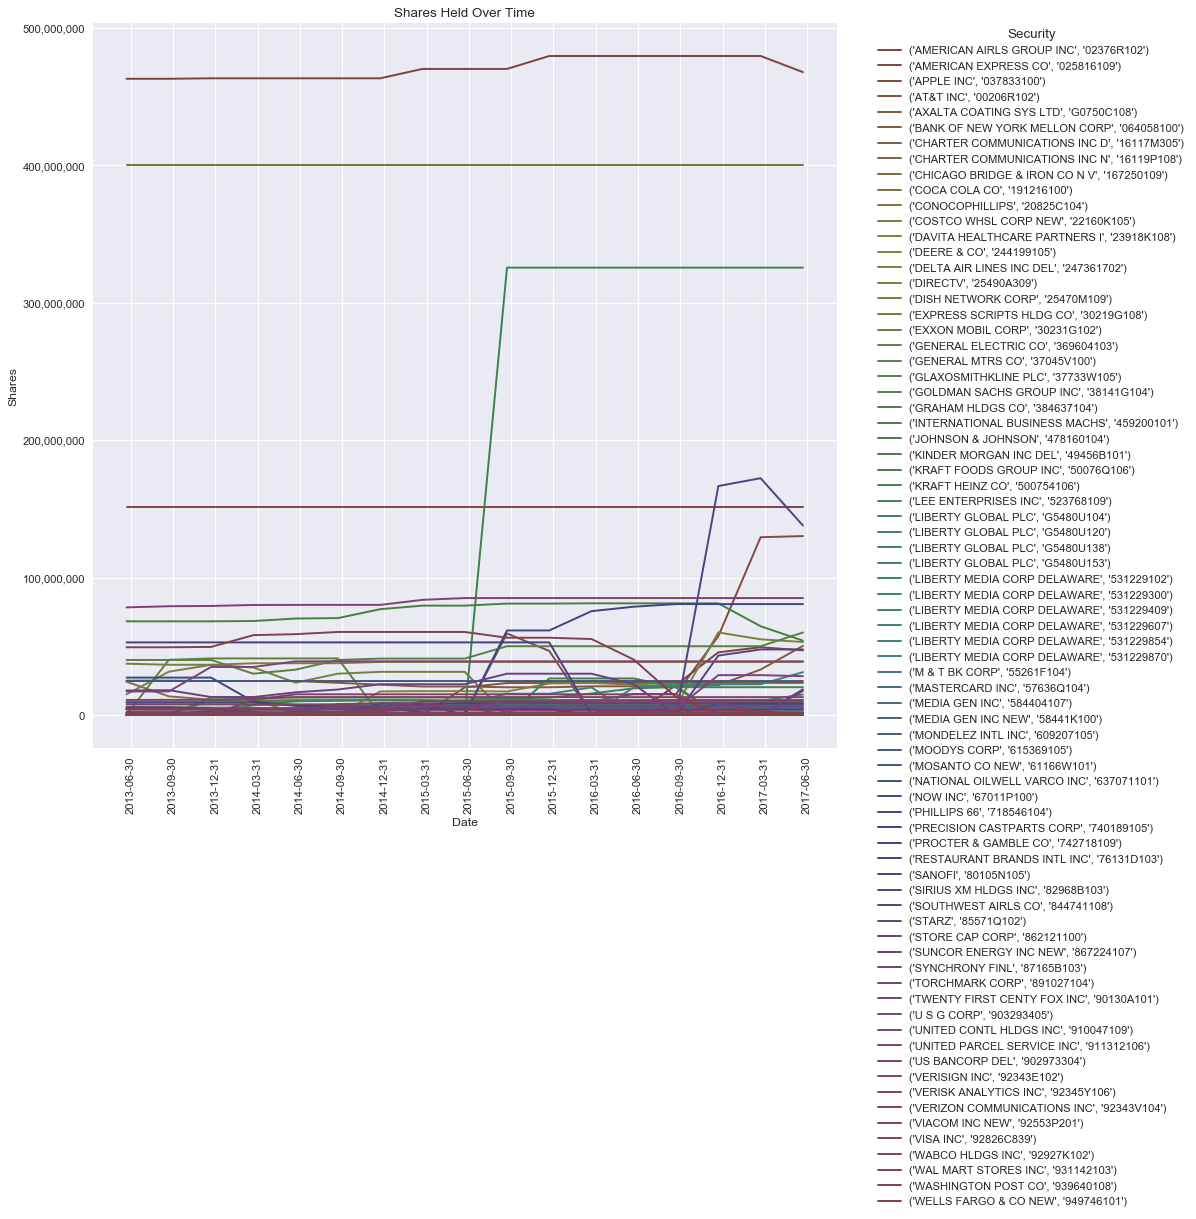

In [12]:
N = len(file_dates)
ind = np.arange(N)    # the x locations for the groups

# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(12, 12), dpi=80)

# Create a new subplot from a grid of 1x1
ax = plt.subplot(1, 1, 1)

for idx, name in enumerate(names):
    plt.plot(ind,df_securities[name], color = colors[idx])

plt.legend(title='Security', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Shares')
plt.xlabel('Date')
plt.title('Shares Held Over Time')

tick_locations = [value + 0.1 for value in ind]
plt.xticks(tick_locations, file_dates, rotation=90)

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
axes = plt.gca()
axes.yaxis.set_major_formatter(tick) 

sns.set()
plt.savefig('./images/shares.png')
plt.show() 

In [13]:
# stacked bar of price change

df_price = pd.DataFrame.copy(df)
df_price.set_index(["cusip","name","file_date"], inplace=True)
df_price.sort_index(inplace=True)
df_price["price_diff"] = df_price["price"].diff()
df_price.reset_index(inplace=True)
#df_price.head()

df_prices = pd.pivot_table(df_price, values='price_diff', index=['file_date'], columns=['name','cusip'], aggfunc=np.sum)
df_prices.fillna(0, inplace= True)
df_prices.head()

name,AMERICAN AIRLS GROUP INC,AMERICAN EXPRESS CO,APPLE INC,AT&T INC,AXALTA COATING SYS LTD,BANK OF NEW YORK MELLON CORP,CHARTER COMMUNICATIONS INC D,CHARTER COMMUNICATIONS INC N,CHICAGO BRIDGE & IRON CO N V,COCA COLA CO,...,US BANCORP DEL,VERISIGN INC,VERISK ANALYTICS INC,VERIZON COMMUNICATIONS INC,VIACOM INC NEW,VISA INC,WABCO HLDGS INC,WAL MART STORES INC,WASHINGTON POST CO,WELLS FARGO & CO NEW
cusip,02376R102,025816109,037833100,00206R102,G0750C108,064058100,16117M305,16119P108,167250109,191216100,...,902973304,92343E102,92345Y106,92343V104,92553P201,92826C839,92927K102,931142103,939640108,949746101
file_date,,,,,,,,,,,,,,,,,,,,,
2013-06-30,0.0,24.440028,0.0,0.0,0.0,-115.970041,0.000000,0.0,-277.190011,0.450162,...,8.109941,-65.929205,15.518959,0.000000,-16.340023,118.109923,-19.089883,-53.020099,408.089540,-570.080502
2013-09-30,0.0,0.759993,0.0,0.0,0.0,2.140036,0.000000,0.0,8.109935,-2.230000,...,0.430003,6.230002,5.260216,0.000000,15.549874,8.349947,9.569894,-0.529999,127.581008,0.049999
2013-12-31,0.0,15.210002,0.0,0.0,0.0,4.750001,0.000000,0.0,15.370094,3.429997,...,3.819997,8.890008,0.759866,0.000000,3.759991,31.580389,9.150154,4.730011,0.000000,4.080000
2014-03-31,0.0,-0.700003,0.0,0.0,0.0,0.349939,0.000000,0.0,4.009945,-2.649998,...,2.459990,-5.869997,-5.759757,-45.390053,-2.350011,-6.820495,12.149914,-2.259998,0.000000,4.340004
2014-06-30,0.0,4.840008,0.0,0.0,0.0,2.190093,107.359764,0.0,-18.949941,3.699998,...,0.459983,-5.100022,0.059484,1.360029,1.740062,-5.149818,1.259958,-1.360007,0.000000,2.819998


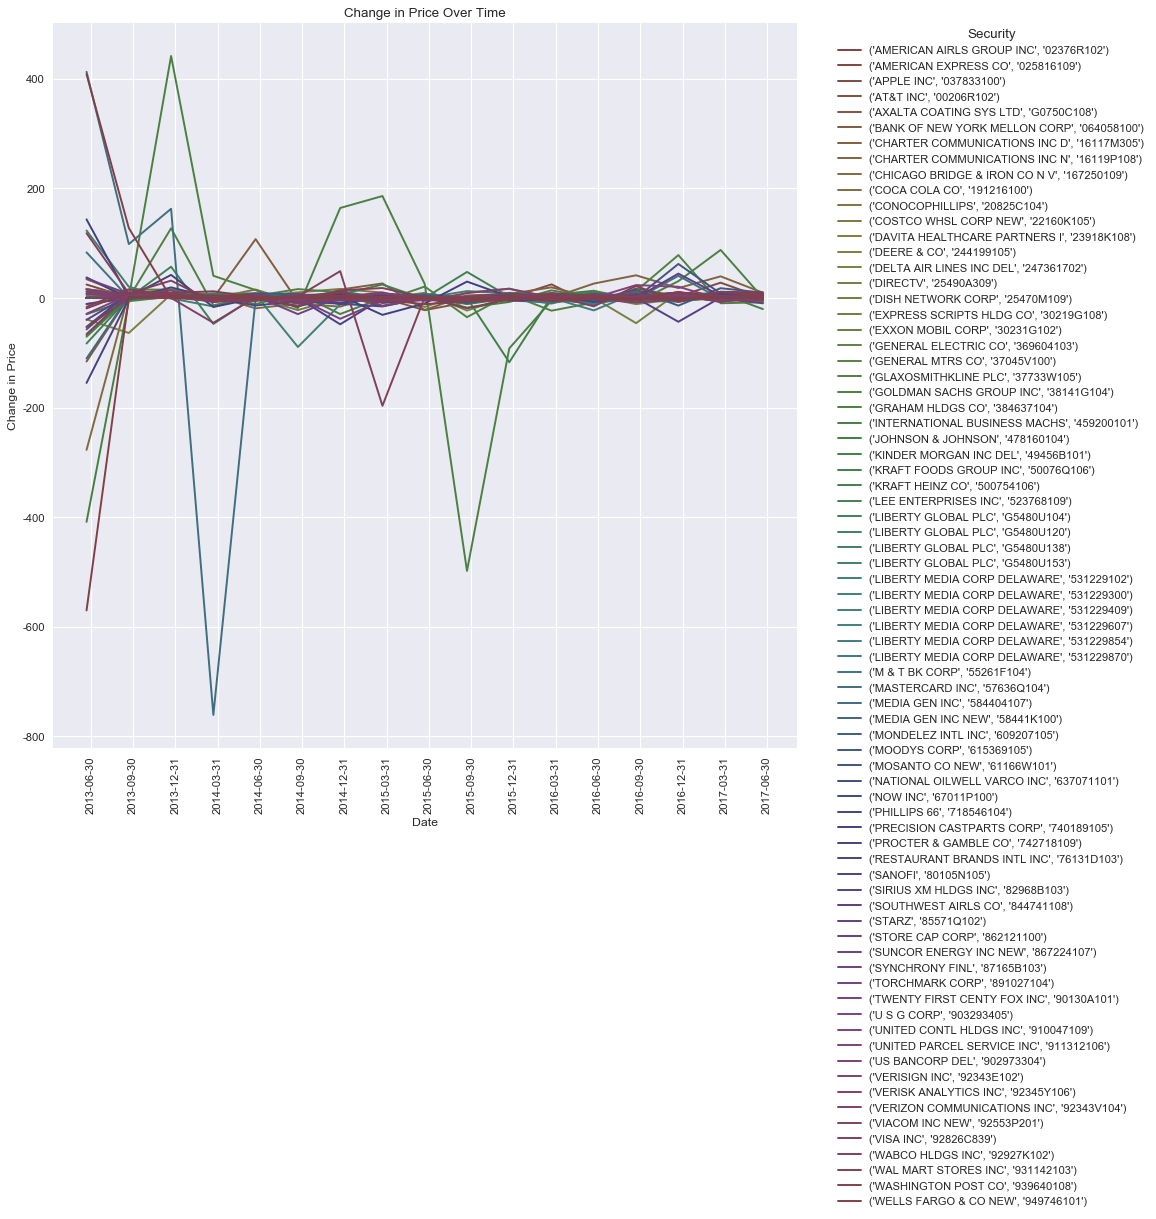

In [14]:
N = len(file_dates)
ind = np.arange(N)    # the x locations for the groups

# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(12, 12), dpi=80)

# Create a new subplot from a grid of 1x1
ax = plt.subplot(1, 1, 1)

for idx, name in enumerate(names):
    plt.plot(ind,df_prices[name], color = colors[idx])

plt.legend(title='Security', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Change in Price')
plt.xlabel('Date')
plt.title('Change in Price Over Time')

tick_locations = [value + 0.1 for value in ind]
plt.xticks(tick_locations, file_dates, rotation=90)

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
axes = plt.gca()
axes.yaxis.set_major_formatter(tick) 

sns.set()
plt.savefig('./images/price_change.png')
plt.show() 

In [15]:
df[df["name"]=="GOLDMAN SACHS GROUP INC"]

,file_date,name,cusip,ticker,indsec,indgrp,mval,shares,price
97,2013-12-31,GOLDMAN SACHS GROUP INC,38141G104,GS,Finance,Investment Bankers/Brokers/Service,2239065000,12631531,177.259985
140,2014-03-31,GOLDMAN SACHS GROUP INC,38141G104,GS,Finance,Investment Bankers/Brokers/Service,2069676000,12631531,163.849972
186,2014-06-30,GOLDMAN SACHS GROUP INC,38141G104,GS,Finance,Investment Bankers/Brokers/Service,2115024000,12631531,167.440036
232,2014-09-30,GOLDMAN SACHS GROUP INC,38141G104,GS,Finance,Investment Bankers/Brokers/Service,2318769000,12631531,183.569909
277,2014-12-31,GOLDMAN SACHS GROUP INC,38141G104,GS,Finance,Investment Bankers/Brokers/Service,2448370000,12631531,193.830027
324,2015-03-31,GOLDMAN SACHS GROUP INC,38141G104,GS,Finance,Investment Bankers/Brokers/Service,2374349000,12631531,187.970009
372,2015-06-30,GOLDMAN SACHS GROUP INC,38141G104,GS,Finance,Investment Bankers/Brokers/Service,2637337000,12631531,208.789972
418,2015-09-30,GOLDMAN SACHS GROUP INC,38141G104,GS,Finance,Investment Bankers/Brokers/Service,1904326000,10959519,173.759998
465,2015-12-31,GOLDMAN SACHS GROUP INC,38141G104,GS,Finance,Investment Bankers/Brokers/Service,1975234000,10959519,180.229990
513,2016-03-31,GOLDMAN SACHS GROUP INC,38141G104,GS,Finance,Investment Bankers/Brokers/Service,1720425000,10959519,156.979973
